In [ ]:
#weights and bias connect
import wandb
from getpass import getpass
!pip install wandb
from google.colab import userdata
userdata.get('WandB')
WANDB_PROJECT='Georgia-Frog-Identification'
WANDB_ENTITY='hikesofgeorgia-hikes-of-georgia-llc'

os.environ["WANDB_API_KEY"] = getpass("Enter your W&B API key: ")
wandb.login()

Enter your W&B API key: ··········


True

In [ ]:
wandb.init(project="Georgia-Frog-Identification", name="hikesofgeorgia-hikes-of-georgia-llc")

# Example logging
wandb.config = {
    "epochs": 10,
    "batch_size": 64,
    "learning_rate": 0.001
}

# During training
wandb.log({"train_loss": loss, "val_accuracy": acc})

NameError: name 'acc' is not defined

In [ ]:
import os

directory_path = '/content/drive/MyDrive/spectrograms'
if os.path.isdir(directory_path):
    print("Contents of the directory:")
    for item in os.listdir(directory_path):
        print(item)
else:
    print(f"Error: {directory_path} is not a valid directory.")

Contents of the directory:
eastern_spadefoot_toad
preview
fowlers_toad
spring_peeper
green_tree_frog
pickerel_frog
not_frogs
northern_cricket_frog
upland_chorus_frog
eastern_narrow_mouthed_toad
green_frog
copes_gray_treefrog
bird_voiced_tree_frog
american_toad
american_bullfrog
southern_leopard_frog


In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import os
import numpy as np # Import numpy
import torch.nn.functional as F # Import functional for tensor transforms

class SpectrogramDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the class subdirectories.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = []
        self.labels = []
        self.classes = sorted([d.name for d in os.scandir(root_dir) if d.is_dir()])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            for filename in os.listdir(class_dir):
                # Check for .npy file extension
                if filename.endswith('.npy'):
                    self.image_files.append(os.path.join(class_dir, filename))
                    self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.image_files[idx]
        # Load .npy file using numpy
        spectrogram = np.load(img_path)

        # Convert numpy array to torch tensor. Assuming the shape is (height, width)
        # and needs to be (channels, height, width) and data type is float32
        image = torch.from_numpy(spectrogram).unsqueeze(0).float()


        label = self.labels[idx]

        if self.transform:
            # Apply transforms that work on tensors
            image = self.transform(image)

        return image, label

# Example usage (replace with your actual root directory and transform)
transform = transforms.Compose([
     # Use transforms that work on tensors
      transforms.Lambda(lambda img: F.interpolate(img.unsqueeze(0), size=(128, 128), mode='bilinear', align_corners=False).squeeze(0)), # Resize tensor
      transforms.Normalize(mean=[0.5], std=[0.5]) # Normalize tensor
 ])
dataset = SpectrogramDataset(root_dir='/content/drive/MyDrive/spectrograms', transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
from torch.utils.data import DataLoader, random_split

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LightCNN(nn.Module):
    def __init__(self, num_classes=10, input_channels=1, dropout_rate=0.3):
        super(LightCNN, self).__init__()


        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2)

        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2)

        self.conv7 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn7 = nn.BatchNorm2d(256)
        self.conv8 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn8 = nn.BatchNorm2d(256)
        self.pool4 = nn.AdaptiveAvgPool2d((1,1))

        #classifier
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(256, num_classes)

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)

        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool3(x)

        x = F.relu(self.bn7(self.conv7(x)))
        x = F.relu(self.bn8(self.conv8(x)))
        x = self.pool4(x)

        x= x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LightCNN(num_classes=len(dataset.classes), input_channels=1).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Initialize Weights & Biases run
wandb.init(project=WANDB_PROJECT, entity=WANDB_ENTITY, reinit=True) # Added reinit=True to allow restarting runs in the same notebook

# Initialize lists to store metrics
train_losses = []
train_accuracies = []

for epoch in range(10):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct_predictions / total_predictions

    # Append metrics to lists
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f"Epoch [{epoch+1}/10], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

    # Log metrics to Weights & Biases
    wandb.log({"epoch": epoch + 1, "train_loss": epoch_loss, "train_accuracy": epoch_acc})

# Finish the Weights & Biases run
wandb.finish()

Epoch [1/10], Loss: 2.2050, Accuracy: 0.3509
Epoch [2/10], Loss: 1.8158, Accuracy: 0.4536
Epoch [3/10], Loss: 1.6495, Accuracy: 0.5107
Epoch [4/10], Loss: 1.5340, Accuracy: 0.5429
Epoch [5/10], Loss: 1.4521, Accuracy: 0.5554
Epoch [6/10], Loss: 1.3257, Accuracy: 0.5982
Epoch [7/10], Loss: 1.3077, Accuracy: 0.6214
Epoch [8/10], Loss: 1.1946, Accuracy: 0.6393
Epoch [9/10], Loss: 1.1388, Accuracy: 0.6554
Epoch [10/10], Loss: 1.0544, Accuracy: 0.6955


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▅▆▆▇▇█
train_loss,█▆▅▄▃▃▃▂▂▁
epoch,10
train_accuracy,0.69554
train_loss,1.05445


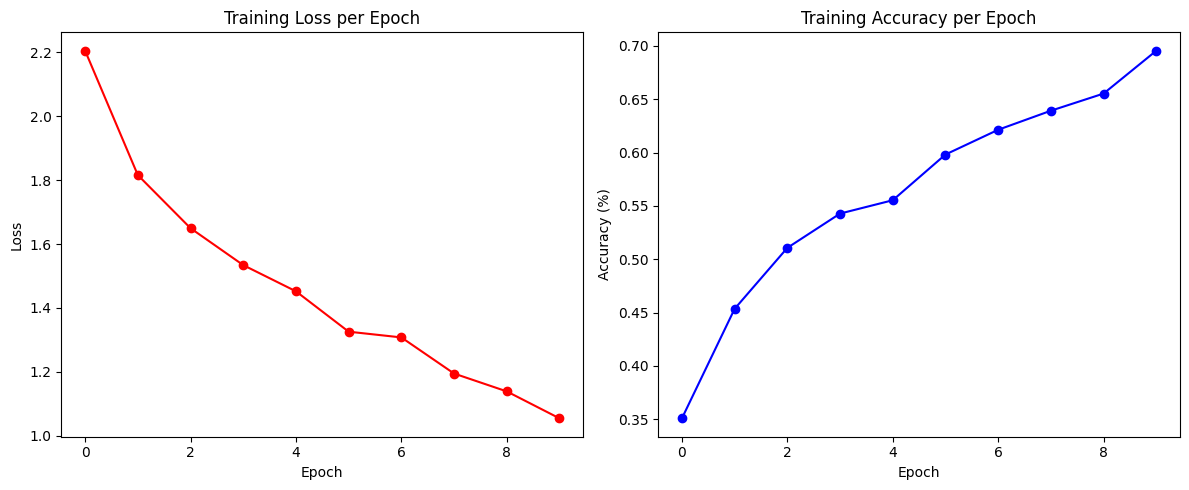

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, 'o-', color='red')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1,2,2)
plt.plot(train_accuracies, 'o-', color='blue')
plt.title('Training Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.tight_layout()
plt.show()

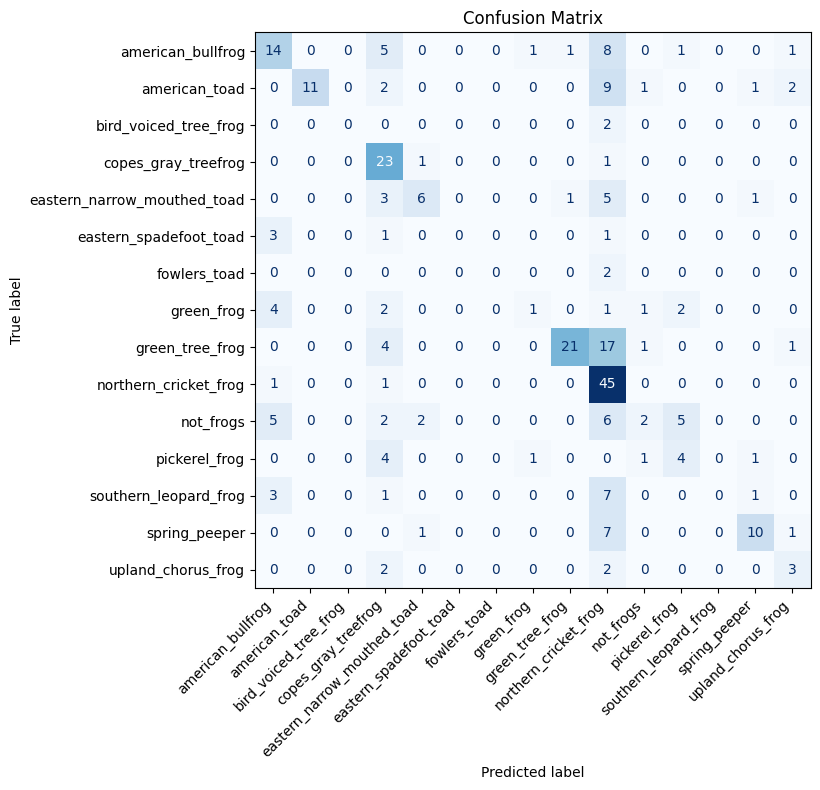

In [48]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt # Import matplotlib

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Get unique labels from the true and predicted values
unique_labels = np.unique(np.concatenate((y_true, y_pred)))

# Generate confusion matrix using only the unique labels
cm = confusion_matrix(y_true, y_pred, labels=unique_labels)

# Get the class names corresponding to the unique labels
display_class_labels = [dataset.classes[i] for i in unique_labels]

# Create ConfusionMatrixDisplay with the confusion matrix and corresponding class labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_class_labels)

# Get the axes object from the plot
fig, ax = plt.subplots(figsize=(10, 8)) # You can adjust the figure size as needed
disp.plot(ax=ax, cmap='Blues', colorbar=False) # Add cmap here

# Explicitly set ticks and labels using the display_class_labels
num_unique_classes = len(unique_labels)
ax.set_xticks(np.arange(num_unique_classes))
ax.set_yticks(np.arange(num_unique_classes))
ax.set_xticklabels(display_class_labels, rotation=45, ha="right")
ax.set_yticklabels(display_class_labels)


plt.title("Confusion Matrix")
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

# Task
Explain how to push a Colab notebook to GitHub.

## Save a copy to github

### Subtask:
Save a copy of your Colab notebook directly to your GitHub repository. This is the easiest way to get the initial version of the notebook onto GitHub.


## Clone the repository in colab

### Subtask:
Clone your GitHub repository into your Colab environment. This will allow you to use Git commands to manage subsequent changes.


In [7]:
!git config --global user.email "cocogirl1105@gmail.com"
!git config --global user.name "adlove8"

In [11]:
!git clone https://github.com/EcologicalDataAlliance/Georgia-Frog-Identification

Cloning into 'Georgia-Frog-Identification'...
remote: Enumerating objects: 107, done.
remote: Counting objects: 100% (107/107), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 107 (delta 24), reused 101 (delta 21), pack-reused 0 (from 0)
Receiving objects: 100% (107/107), 3.58 MiB | 25.29 MiB/s, done.
Resolving deltas: 100% (24/24), done.


In [15]:
!mv /content/modeling.ipynb /content/Georgia-Frog-Identification/

mv: cannot stat '/content/modeling.ipynb': No such file or directory
